# Analyses of session clusters


In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
import pandas as pd
from one.api import ONE
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go 

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
import umap
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//4_analyses/4_Clustering/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from clustering_functions import revert_to_original, get_ballistic, get_no_resp

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//4_analyses/4_Clustering/'

## Get data

In [3]:
# Full file path for dumping
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/')

# DATA used for COSYNE: states_trial_type_14oct2024

In [32]:
# Load trial clsuters
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
trials_filename = str(results_path + 'cluster_per_trial01-09-2025')
old_trial_clusters = pd.read_parquet(trials_filename, engine='pyarrow')
# mouse_filename = str(results_path + 'cluster_per_mouse01-09-2025')
# old_mouse_clusters = pd.read_parquet(mouse_filename, engine='pyarrow')


# Load trial clsuters
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
trials_filename = str(results_path + 'cluster_per_trial_no_timing03-11-2025')
trial_clusters = pd.read_parquet(trials_filename, engine='pyarrow')

session_filename = str(results_path + 'cluster_per_session03-11-2025')
session_clusters = pd.read_parquet(session_filename, engine='pyarrow')

In [33]:
session_clusters = session_clusters.merge(trial_clusters[['session', 'mouse_name']].drop_duplicates(), on='session')

In [34]:
trial_clusters = trial_clusters.merge(old_trial_clusters[['sample', 'mouse_name', 
                                                          'perseverence', 'wsls', 'ballistic']], on=['sample', 'mouse_name'])

## Plot session cluster features

In [35]:
mean_cluster_session = pd.DataFrame(session_clusters.groupby(['session_cluster', 'cluster'])['relative_frequency'].mean()).reset_index()


In [36]:
if session_filename == str(results_path + 'cluster_per_mouse01-09-2025'):

    plt_vars = ['Right ballistic', 'Right choice, low contrast','Long pre-quiescence', 
                'Left ballistic', 'Left, long pre-quiescence', 'Long reaction'] 
    unique_clusters = [3, 2, 1, 0, 5, 4]
    new_dict = {3:0, 0:3, 2:1, 1:2, 4:5, 5:4}
else:
    plt_vars = ['0', '1', '2', '3', '4', '5', '6'] 

    unique_clusters = [0, 1, 2, 3, 4, 5, 6]
    new_dict = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6}

    # unique_clusters = [3, 0, 2, 1, 4, 5]
    # new_dict = {3:0, 0:1, 2:2, 1:3, 4:4, 5:5}

# {unique: key for unique, key in zip(state_labels, int_state)}
mapping = {
    cluster: label
    for cluster, label in zip(unique_clusters, plt_vars)
}
mapping
replace_func = np.vectorize(mapping.get)

replace_func = np.vectorize(new_dict.get)
mean_cluster_session['new_clusters'] = mean_cluster_session['cluster'].copy()
mean_cluster_session['new_clusters'] = replace_func(mean_cluster_session['cluster'])


In [37]:
mean_cluster_session['label'] = mean_cluster_session['cluster'].copy()
mean_cluster_session['label'] = replace_func(mean_cluster_session['label'])

mean_cluster_session.sort_values(by='label')

# Custom order (array) for the 'name' column
custom_order = ['Right ballistic','Accurate, long pre-quiescence','Long reaction', 'Left ballistic',
            'Left non-ballistic','Right non-ballistic'] 
custom_order = ['0', '1', '2', '3', '4', '5', '6']

# Convert the 'name' column to a categorical type with the specified order
mean_cluster_session['label'] = pd.Categorical(mean_cluster_session['label'], categories=custom_order, ordered=True)


In [38]:

plt.rcParams.update({'font.size': 16})

# plot star plot for comparison 
fig = go.Figure() 
fig.add_trace(go.Scatterpolar( 
      r=pd.Series(mean_cluster_session.sort_values(by='new_clusters').loc[mean_cluster_session['session_cluster']==0, 'relative_frequency'].values), 
      theta=plt_vars, 
      fill='toself', 
      name='Session cluster 0' 
)) 
fig.add_trace(go.Scatterpolar( 
      r=pd.Series(mean_cluster_session.sort_values(by='new_clusters').loc[mean_cluster_session['session_cluster']==1, 'relative_frequency'].values), 
      theta=plt_vars, 
      fill='toself', 
      name='Session cluster 1'
)) 

fig.add_trace(go.Scatterpolar( 
      r=pd.Series(mean_cluster_session.sort_values(by='new_clusters').loc[mean_cluster_session['session_cluster']==2, 'relative_frequency'].values), 
      theta=plt_vars, 
      fill='toself', 
      name='Session cluster 2'
)) 

fig.add_trace(go.Scatterpolar( 
      r=pd.Series(mean_cluster_session.sort_values(by='new_clusters').loc[mean_cluster_session['session_cluster']==3, 'relative_frequency'].values), 
      theta=plt_vars, 
      fill='toself', 
      name='Session cluster 3'
)) 

fig.add_trace(go.Scatterpolar( 
      r=pd.Series(mean_cluster_session.sort_values(by='new_clusters').loc[mean_cluster_session['session_cluster']==4, 'relative_frequency'].values), 
      theta=plt_vars, 
      fill='toself', 
      name='Session cluster 4'
)) 

# fig.add_trace(go.Scatterpolar( 
#       r=pd.Series(mean_cluster_mice.sort_values(by='new_clusters').loc[mean_cluster_mice['mouse_cluster']==3, 'relative_frequency'].values), 
#       theta=plt_vars, 
#       fill='toself', 
#       name='Mouse cluster 3'
# )) 
  
fig.update_layout( 
  polar=dict(
        angularaxis=dict(
            tickfont=dict(size=16)  # Set the font size of the theta labels
        ),
    radialaxis=dict( 
      visible=True,
      tickfont=dict(size=16)
          )), 
  
  showlegend=True
)  #     template = 'plotly_dark', 

# plt.savefig(file_path+'star_plots_mice.svg', format="svg")
fig.write_image(file_path + 'star_plots_mice.svg')

fig.show() 

Text(0.5, 0, 'Session cluster')

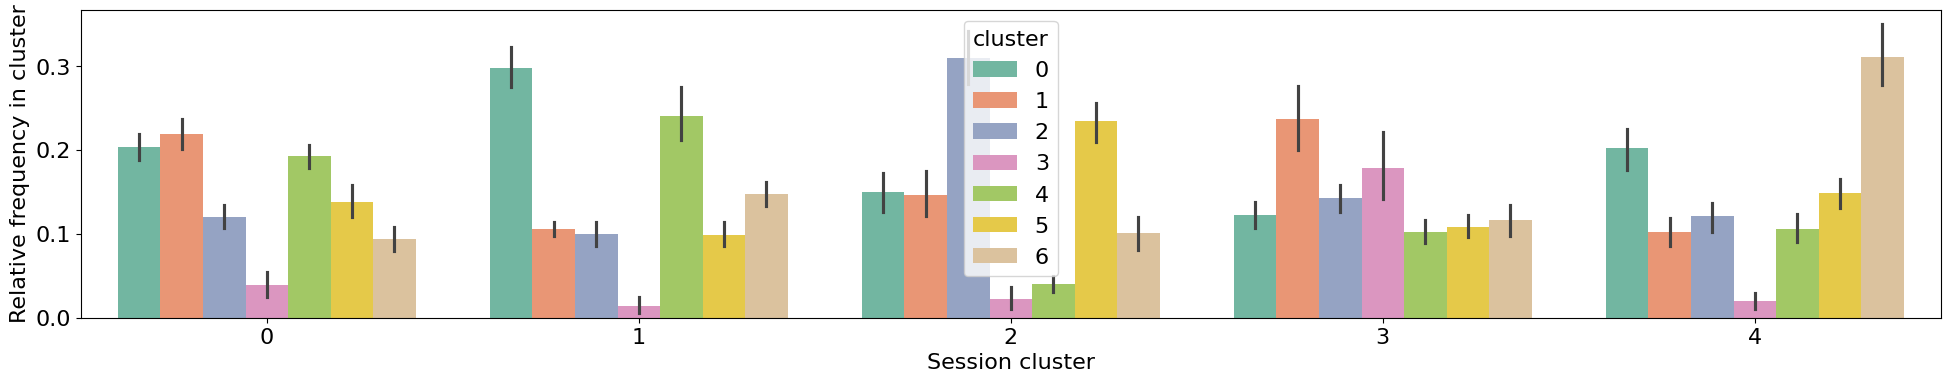

In [39]:
fig, ax = plt.subplots(figsize=(24, 4))
sns.barplot(x='session_cluster', y='relative_frequency', hue='cluster', data=session_clusters, palette='Set2')
plt.ylabel('Relative frequency in cluster')
plt.xlabel('Session cluster')

## Merge trial info and mouse clusters

In [43]:
session_trials_df = trial_clusters.merge(session_clusters[['session', 'session_cluster']])
new_df = pd.DataFrame(session_trials_df.groupby(['mouse_name', 'session_cluster', 'session'])[['reaction', 'response', 
                                                                                          'elongation', 'feedback', 'ballistic']].mean()).reset_index()
# new_df = pd.DataFrame(new_df.groupby(['mouse_name', 'mouse_cluster'])['reaction', 'response', 'elongation', 'correct', 'ballistic'].mean()).reset_index()

/tmp/ipykernel_48490/3528273056.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_48490/3528273056.py:5: UserWarning:


The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.

/tmp/ipykernel_48490/3528273056.py:6: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



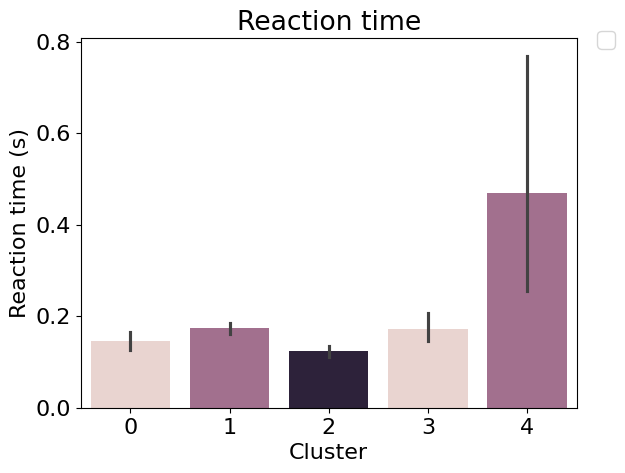

/tmp/ipykernel_48490/3528273056.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_48490/3528273056.py:14: UserWarning:


The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.

/tmp/ipykernel_48490/3528273056.py:15: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



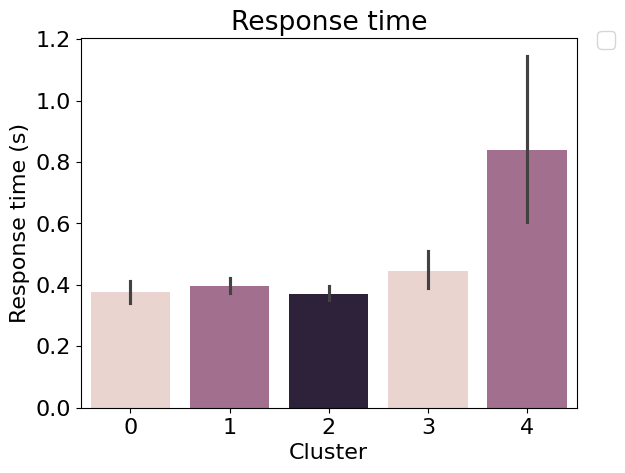

/tmp/ipykernel_48490/3528273056.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_48490/3528273056.py:23: UserWarning:


The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.

/tmp/ipykernel_48490/3528273056.py:24: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



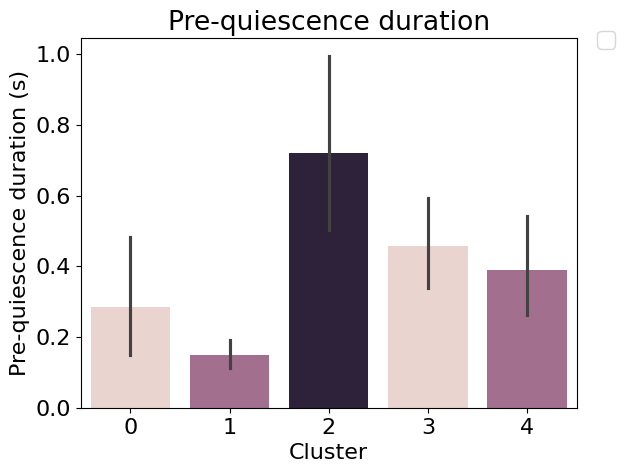

In [17]:
session_trials_df = trial_clusters.merge(session_clusters[['session', 'session_cluster']])
new_df = pd.DataFrame(session_trials_df.groupby(['mouse_name', 'session_cluster', 'session'])[['reaction', 'response', 
                                                                                          'elongation']].median()).reset_index()

sns.barplot(x='session_cluster', y='reaction', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Reaction time')
plt.ylabel('Reaction time (s)')
plt.xlabel('Cluster')
plt.savefig(file_path+'reaction_mouse.svg', format="svg")

plt.show()

sns.barplot(x='session_cluster', y='response', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Response time')
plt.ylabel('Response time (s)')
plt.savefig(file_path+'response_mouse.svg', format="svg")

plt.xlabel('Cluster')
plt.show()

sns.barplot(x='session_cluster', y='elongation', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Pre-quiescence duration')
plt.ylabel('Pre-quiescence duration (s)')
plt.savefig(file_path+'elongation_mouse.svg', format="svg")

plt.xlabel('Cluster')
plt.show()


/tmp/ipykernel_48490/101336174.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_48490/101336174.py:5: UserWarning:


The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.

/tmp/ipykernel_48490/101336174.py:6: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



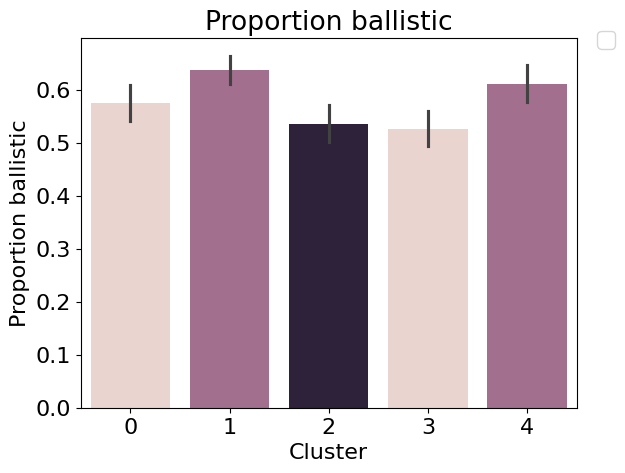

/tmp/ipykernel_48490/101336174.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_48490/101336174.py:14: UserWarning:


The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.

/tmp/ipykernel_48490/101336174.py:15: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



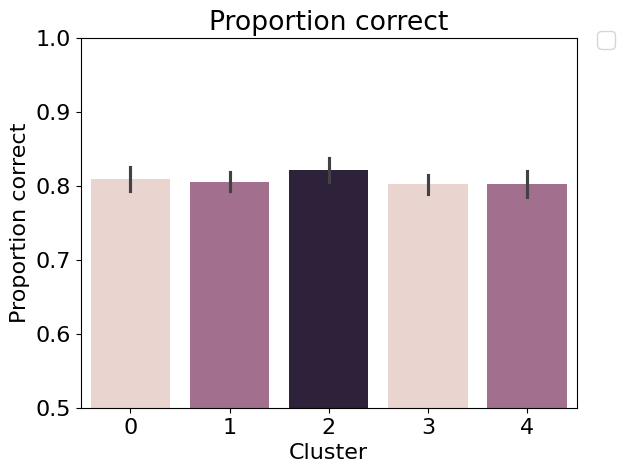

/tmp/ipykernel_48490/101336174.py:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_48490/101336174.py:24: UserWarning:


The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.

/tmp/ipykernel_48490/101336174.py:25: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



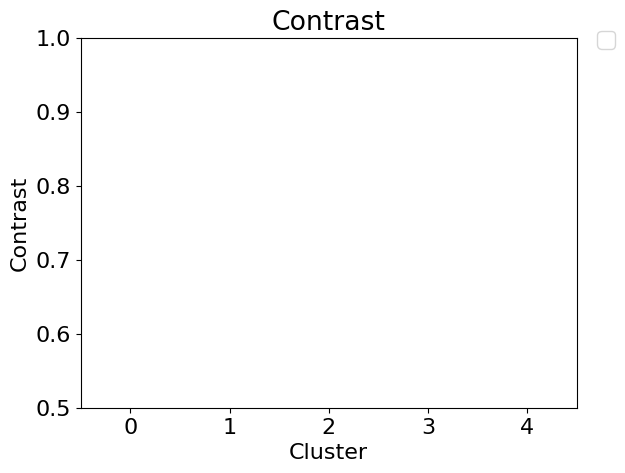

/tmp/ipykernel_48490/101336174.py:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_48490/101336174.py:34: UserWarning:


The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.

/tmp/ipykernel_48490/101336174.py:35: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



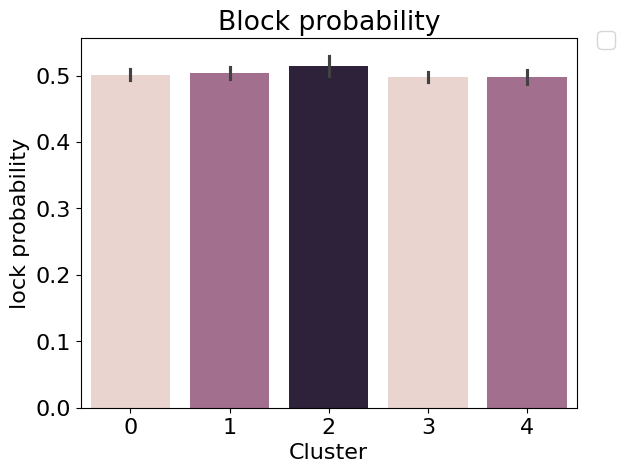

In [18]:
session_trials_df = trial_clusters.merge(session_clusters[['session', 'session_cluster']])
new_df = pd.DataFrame(session_trials_df.groupby(['mouse_name', 'session_cluster', 'session'])[['feedback', 'ballistic',
                                                                                           'contrast', 'block']].mean()).reset_index()

sns.barplot(x='session_cluster', y='ballistic', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion ballistic')
plt.ylabel('Proportion ballistic')
plt.savefig(file_path+'ballistic_mouse.svg', format="svg")

plt.xlabel('Cluster')
plt.show()

sns.barplot(x='session_cluster', y='feedback', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion correct')
plt.ylabel('Proportion correct')
plt.savefig(file_path+'correct_mouse.svg', format="svg")

plt.xlabel('Cluster')
plt.ylim([.5, 1])
plt.show()

sns.barplot(x='session_cluster', y='contrast', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Contrast')
plt.ylabel('Contrast')
# plt.savefig(file_path+'correct_mouse.svg', format="svg")

plt.xlabel('Cluster')
plt.ylim([.5, 1])
plt.show()

sns.barplot(x='session_cluster', y='block', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Block probability')
plt.ylabel('lock probability')
# plt.savefig(file_path+'ballistic_mouse.svg', format="svg")
plt.xlabel('Cluster')
plt.show()



In [ ]:
# Perform two-sample t-test

group_1 = new_df.loc[new_df['mouse_cluster']==0, 'ballistic']
group_2 = new_df.loc[new_df['mouse_cluster']==2, 'ballistic']
t_stat, p_value = ttest_ind(group_1, group_2)
print(f"t-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

t-statistic: 2.703
P-value: 0.010


In [44]:

data_path =  '/home/ines/repositories/representation_learning_variability/DATA/'
os.chdir(data_path)
learning_df = pd.read_csv('learning_private_one.csv')  
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()
df = new_df.merge(learning_times, on='mouse_name')

/tmp/ipykernel_48490/3565219939.py:3: DtypeWarning:

Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.



                       sum_sq     df         F    PR(>F)
session_cluster    528.910186    1.0  2.881312  0.091101
Residual         38365.241473  209.0       NaN       NaN
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1  -3.0638 0.8402 -11.2327   5.105  False
     0      2  -8.3806 0.0862 -17.4655  0.7043  False
     0      3  -4.6733 0.5047 -12.7562  3.4096  False
     0      4  -5.3269 0.4752 -14.2791  3.6253  False
     1      2  -5.3168  0.391 -13.5607  2.9271  False
     1      3  -1.6095 0.9715  -8.7341  5.5151  False
     1      4  -2.2631 0.9392 -10.3605  5.8344  False
     2      3   3.7073 0.7217  -4.4515  11.866  False
     2      4   3.0537 0.8843  -5.9671 12.0744  False
     3      4  -0.6536 0.9994  -8.6643  7.3571  False
-----------------------------------------------------


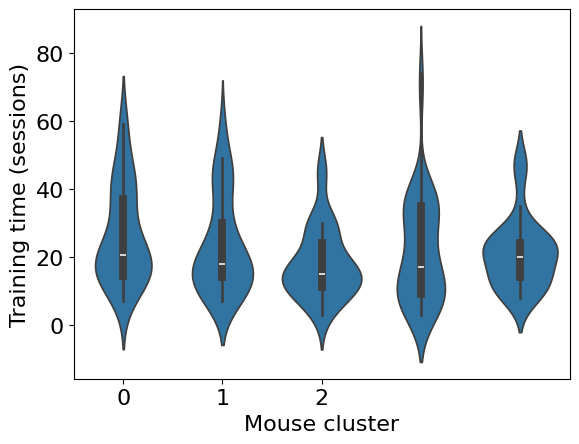

P-value for KW: 0.062
          0    1         2         3    4
0  1.000000  1.0  0.202361  0.581962  1.0
1  1.000000  1.0  1.000000  1.000000  1.0
2  0.202361  1.0  1.000000  1.000000  1.0
3  0.581962  1.0  1.000000  1.000000  1.0
4  1.000000  1.0  1.000000  1.000000  1.0


In [51]:

var_1 = 'training_time ~ session_cluster'
var = 'training_time'
# var = 'elongation'
# var_1 = 'elongation ~ mouse_cluster'
# Define the model using ordinary least squares (OLS) and fit it
data = df.dropna()
# data = pd.DataFrame(df.groupby(['mouse_name', 'mouse_cluster'])[var].mean()).reset_index().dropna()

model = ols(var_1, data=data).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame

print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=data[var], groups=data['session_cluster'], alpha=0.05)

print(tukey)
plt.rcParams.update({'font.size': 16})
sns.violinplot(x='session_cluster', y=var, data=data)
plt.xticks([0, 1, 2], [0, 1, 2])
# plt.ylim([0, 2])
plt.xlabel('Mouse cluster')
plt.ylabel('Proportion correct')
plt.ylabel('Training time (sessions)')
plt.savefig(file_path+'training_time.svg', format="svg")

plt.show()


group_1 = df.loc[df['session_cluster']==0, var]
group_2 = df.loc[df['session_cluster']==1, var]
group_3 = df.loc[df['session_cluster']==2, var]
group_4 = df.loc[df['session_cluster']==3, var]
group_5 = df.loc[df['session_cluster']==4, var]

stat, p_value = stats.kruskal(group_1, group_2, group_3)
# stat, p_value = stats.kruskal(group_1, group_2)

print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(df.dropna(), val_col=var, group_col='session_cluster', p_adjust='bonferroni')
print(posthoc)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


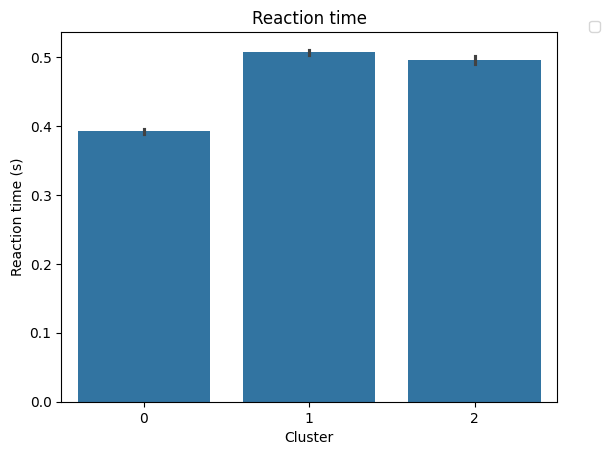

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


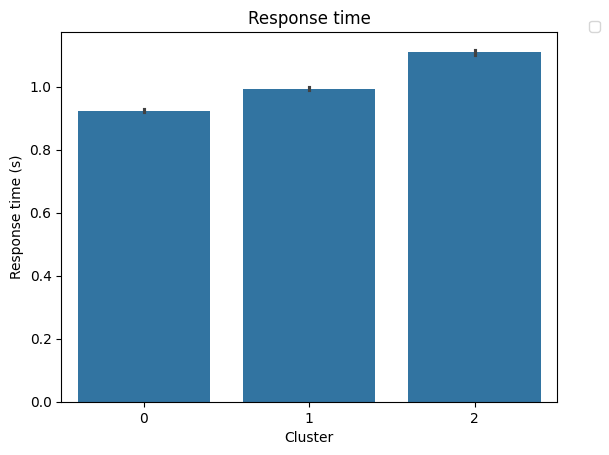

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


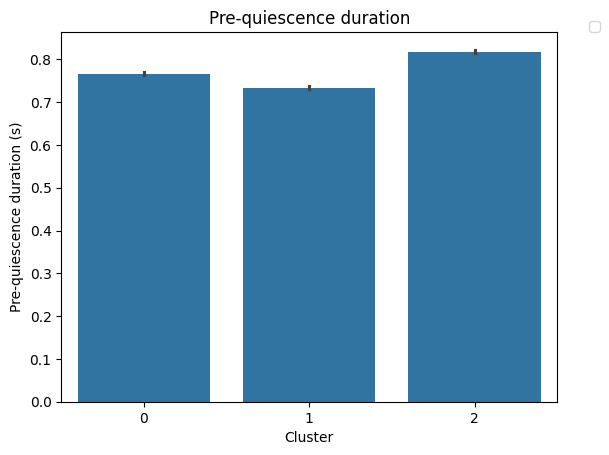

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


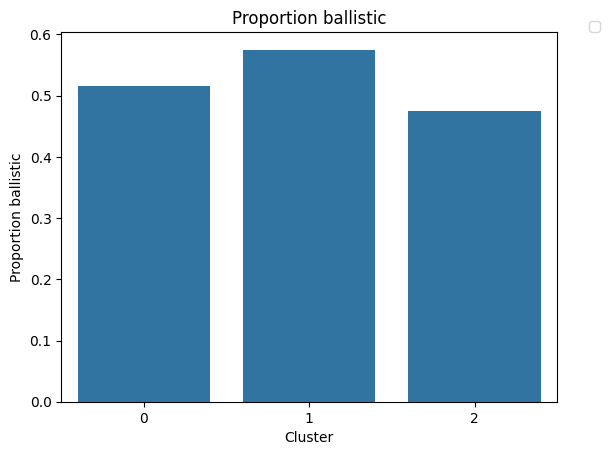

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


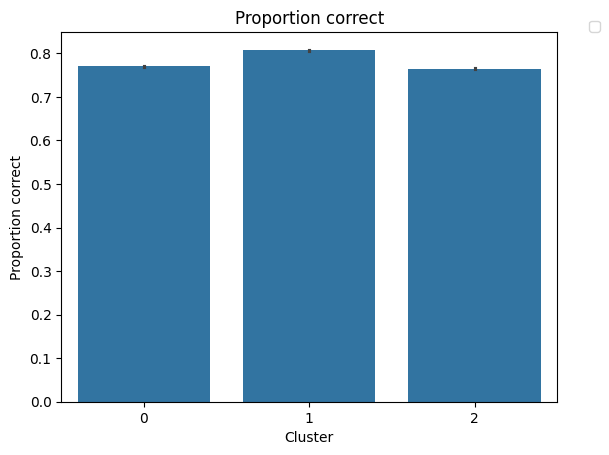

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


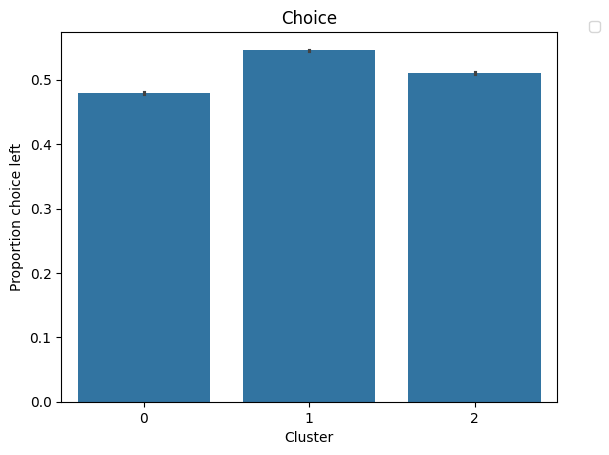

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


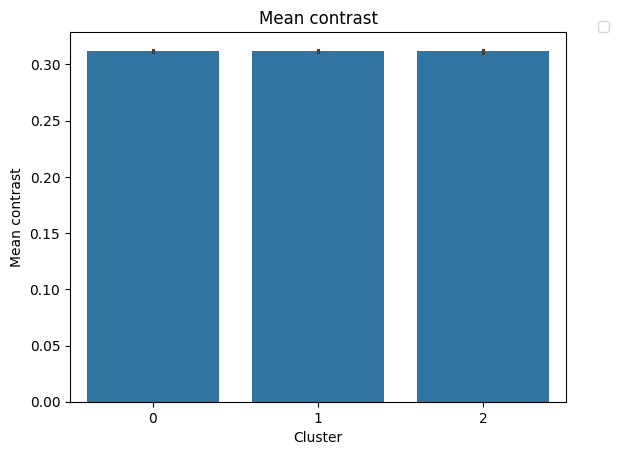

In [49]:
sns.barplot(x='cluster', y='reaction', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Reaction time')
plt.ylabel('Reaction time (s)')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='response', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Response time')
plt.ylabel('Response time (s)')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='elongation', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Pre-quiescence duration')
plt.ylabel('Pre-quiescence duration (s)')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='ballistic', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion ballistic')
plt.ylabel('Proportion ballistic')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='correct', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion correct')
plt.ylabel('Proportion correct')
plt.xlabel('Cluster')
# plt.ylim([.6, .9])
plt.show()

use_data = df_cluster.copy()
use_data.loc[use_data['choice']=='left', 'choice'] = 1
use_data.loc[use_data['choice']=='right', 'choice'] = 0
sns.barplot(x='cluster', y='choice', data=use_data)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Choice')
plt.ylabel('Proportion choice left')
plt.xlabel('Cluster')
plt.show()

sns.barplot(x='cluster', y='contrast', data=df_cluster)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Mean contrast')
plt.ylabel('Mean contrast')
plt.xlabel('Cluster')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


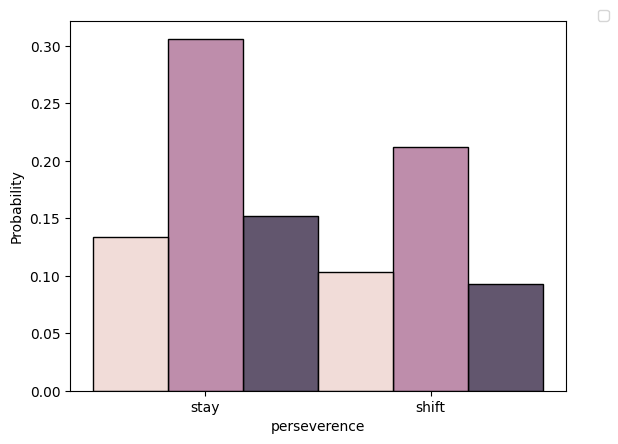

In [ ]:
sns.histplot(x='perseverence', hue='cluster', data=df_cluster, stat='probability', multiple='dodge')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('')
plt.show()


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/4_Clustering/clustering_functions.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



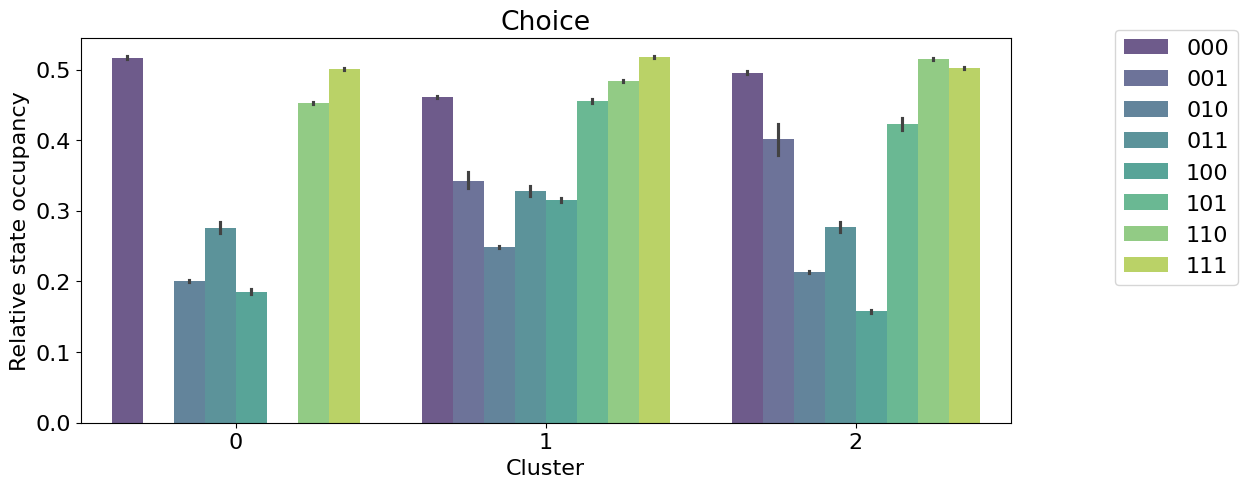

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/4_Clustering/clustering_functions.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



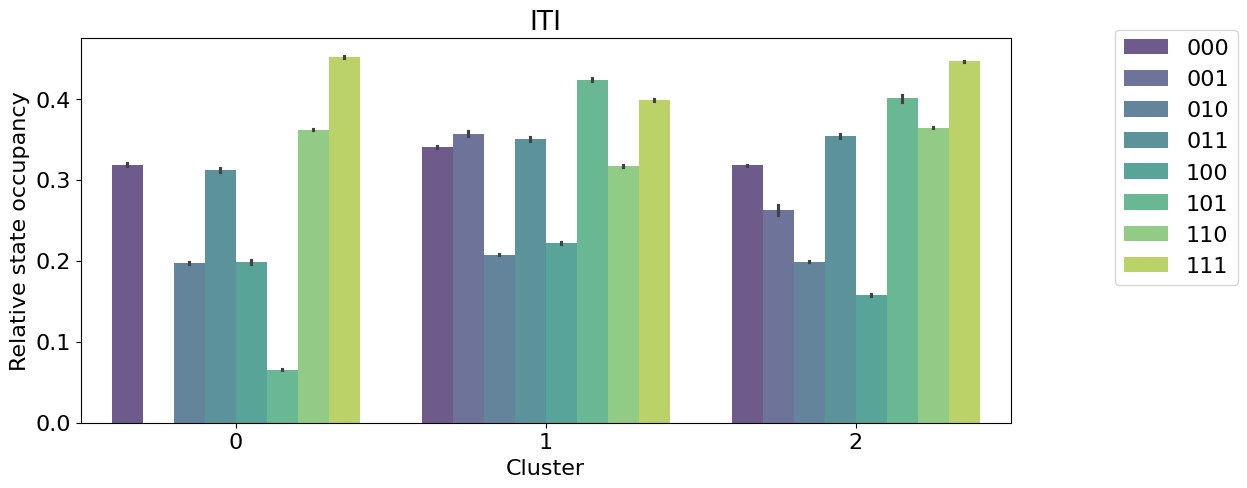

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/4_Clustering/clustering_functions.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



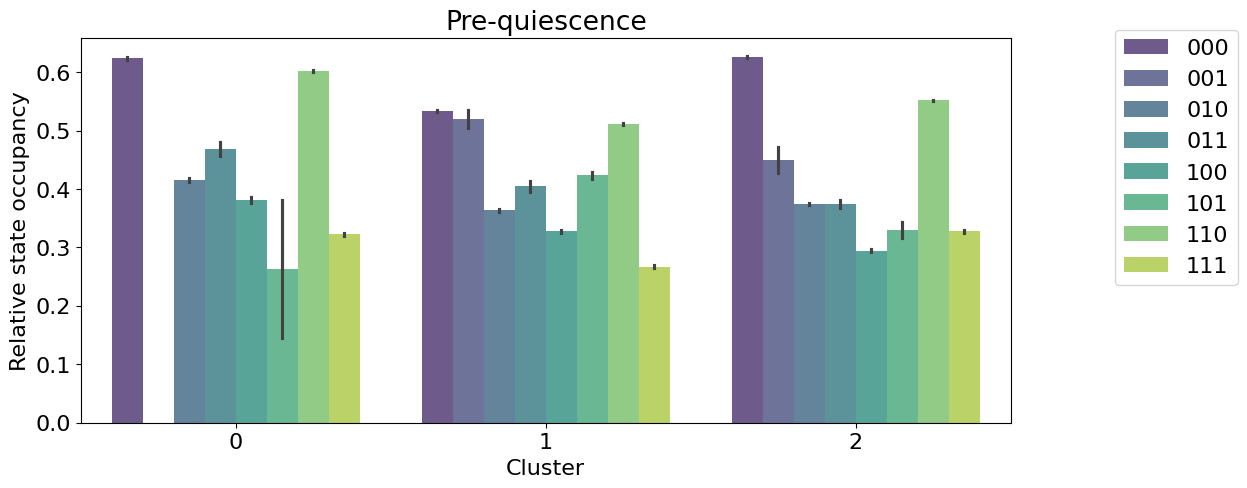

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/4_Clustering/clustering_functions.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



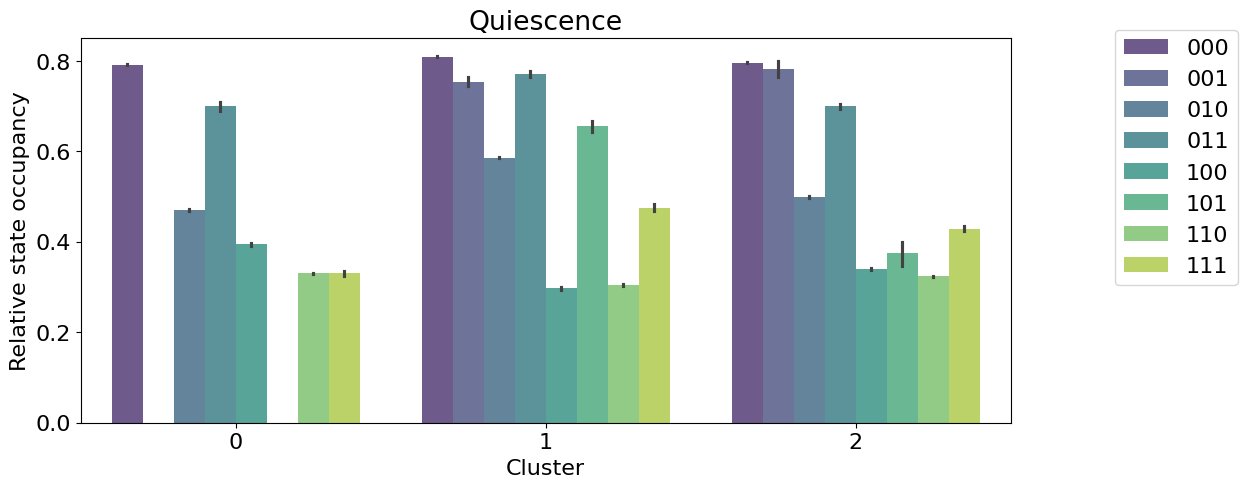

In [95]:
for e, epoch in enumerate(mouse_trials_df['broader_label'].unique()):
    use_data = mouse_trials_df.loc[mouse_trials_df['broader_label']==epoch]
    use_data = revert_to_original(use_data)
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.barplot(hue='original_states', y='relative_frequency', x='mouse_cluster', alpha=0.8,
                hue_order = ['000', '001', '010', '011', '100', '101', '110','111'], data=use_data, palette='viridis')
    plt.xlabel('Cluster')
    plt.ylabel('Relative state occupancy')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(epoch)
    plt.show()

## Plot ballistic stats per cluster

ValueError: Could not interpret value `ballistic` for `hue`. An entry with this name does not appear in `data`.

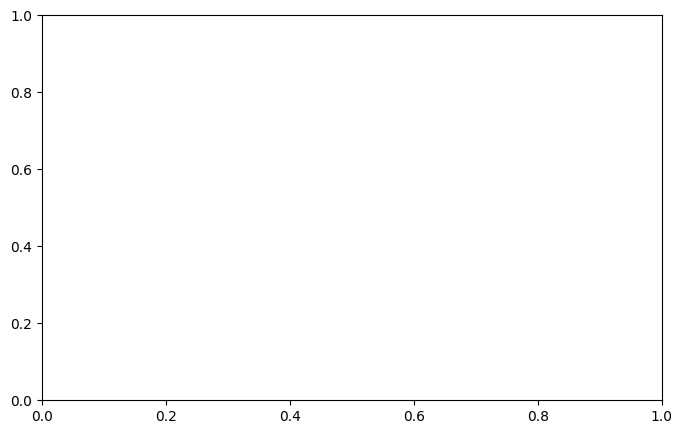

In [ ]:

labels = ['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI']
colors = sns.color_palette('tab10')[0:2]
count['broader_label'] = pd.Categorical(count['broader_label'], categories=labels)
fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(x='broader_label', y='count', data=count, hue='ballistic')
plt.xlabel('Trial epoch')
plt.ylabel('Relative frequency')
# plt.xticks(rotation=45, ha='right')
# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()
# except:

/tmp/ipykernel_42178/4245298614.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['bal_state'] = use_data['identifiable_states'].copy()


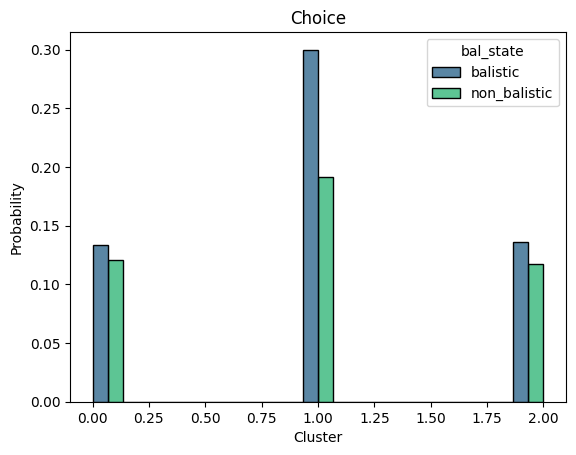

/tmp/ipykernel_42178/4245298614.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['bal_state'] = use_data['identifiable_states'].copy()


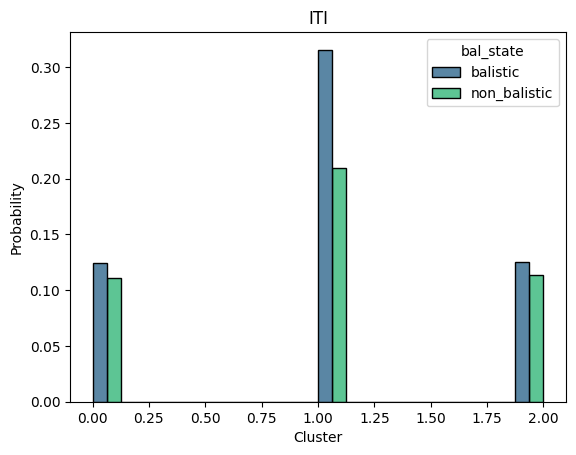

/tmp/ipykernel_42178/4245298614.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['bal_state'] = use_data['identifiable_states'].copy()


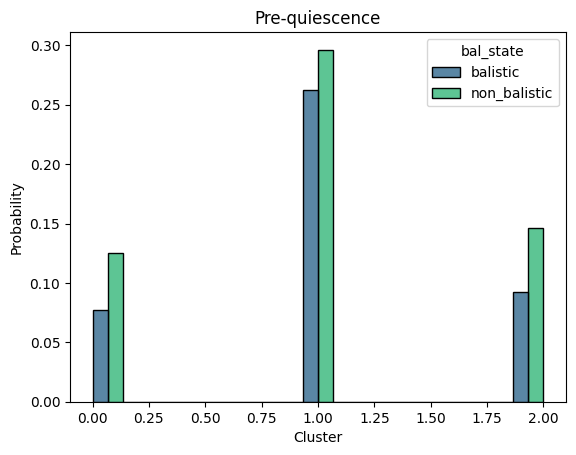

/tmp/ipykernel_42178/4245298614.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['bal_state'] = use_data['identifiable_states'].copy()


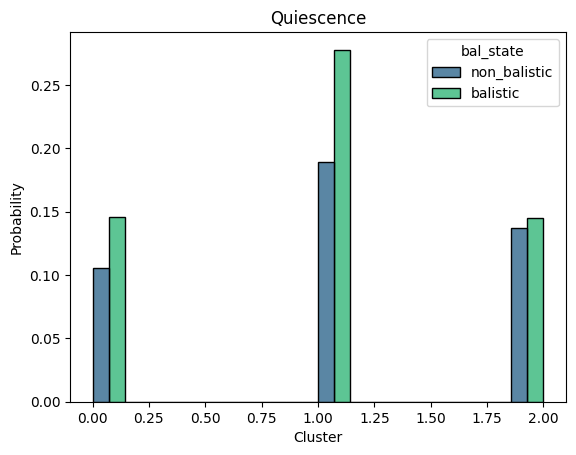

/tmp/ipykernel_42178/4245298614.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['bal_state'] = use_data['identifiable_states'].copy()


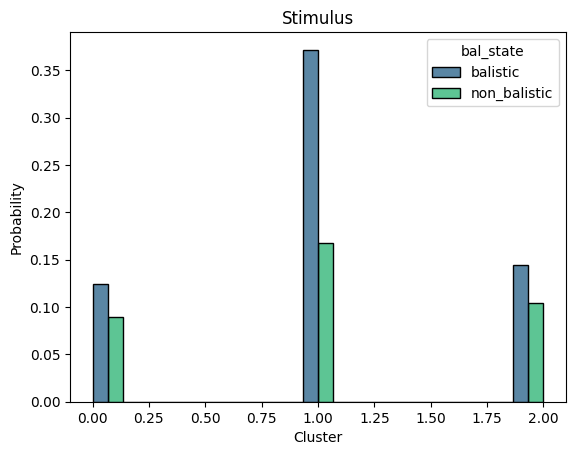

In [ ]:
for e, epoch in enumerate(df_cluster['broader_label'].unique()):
    use_data = df_cluster.loc[df_cluster['broader_label']==epoch]
    use_data = get_ballistic(use_data)
    sns.histplot(hue='bal_state', x='cluster', alpha=0.8,data=use_data, stat='probability', multiple='dodge', palette='viridis')
    plt.xlabel('Cluster')
    # plt.ylabel('Proportion ballistic')
    # plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(epoch)
    plt.show()

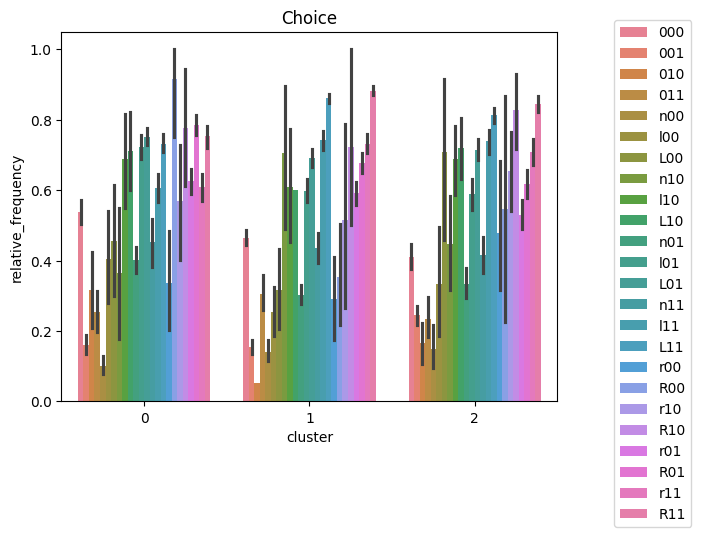

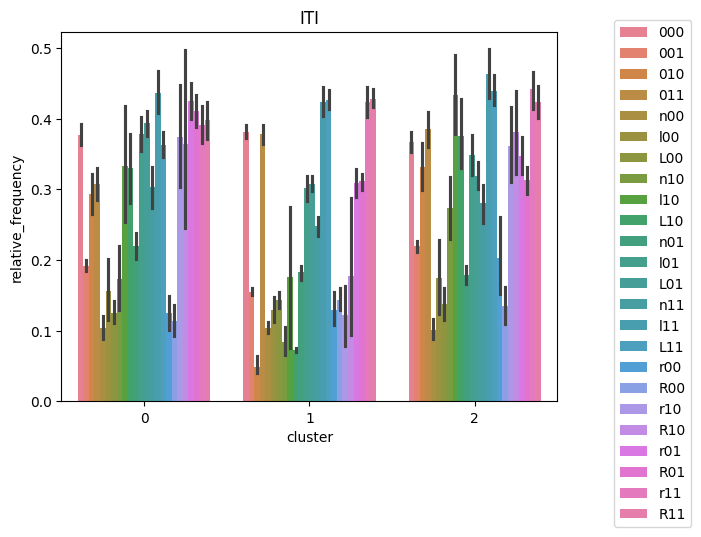

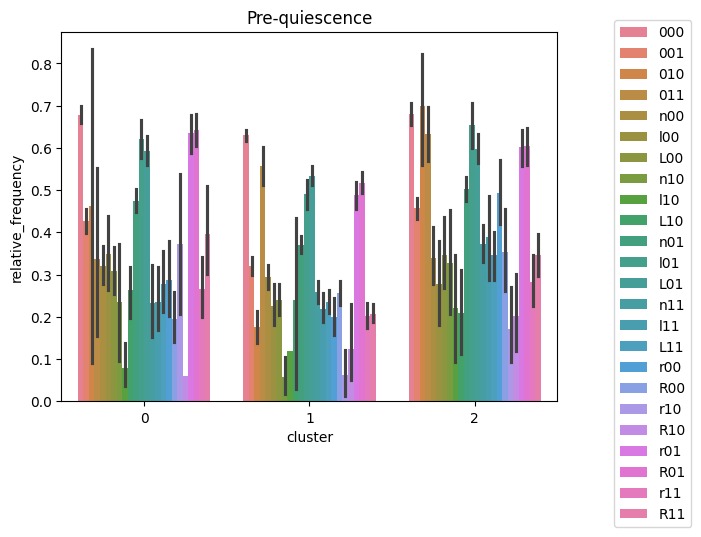

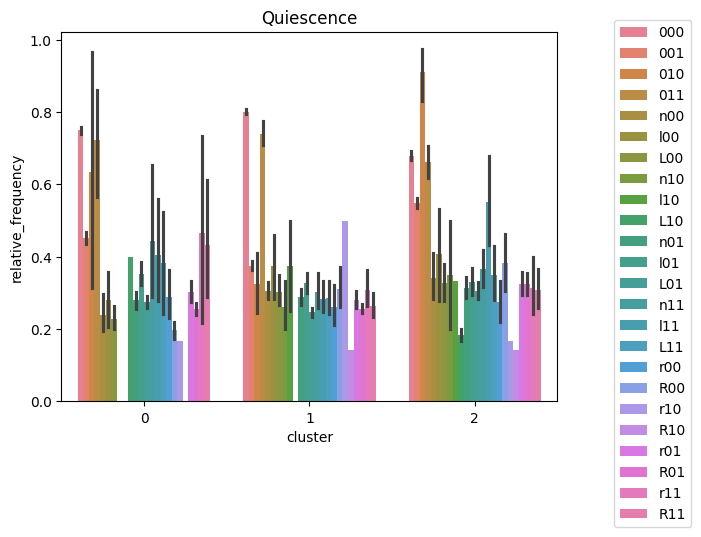

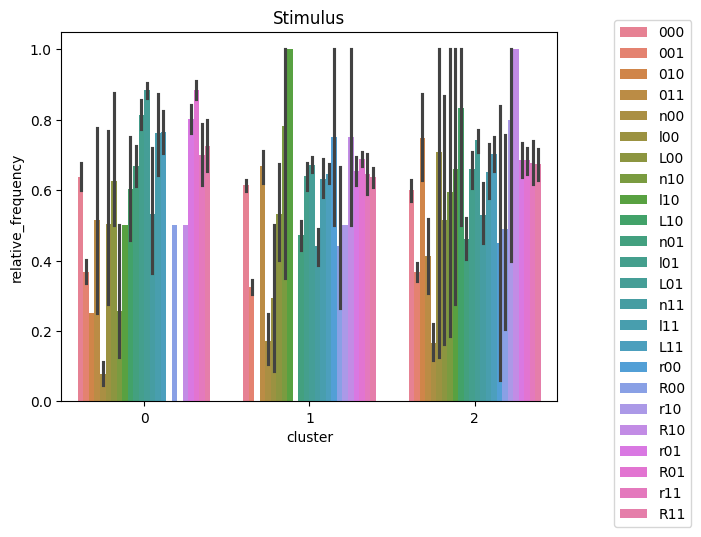

In [ ]:
for e, epoch in enumerate(df_cluster['broader_label'].unique()):
    use_data = df_cluster.loc[df_cluster['broader_label']==epoch]
    sns.barplot(hue='identifiable_states', y='relative_frequency', x='cluster', 
                hue_order = ['000', '001', '010', '011', 'n00', 'l00', 'L00',
                             'n10', 'l10', 'L10', 'n01', 'l01', 'L01', 'n11', 'l11', 'L11',
                             'r00', 'R00', 'r10', 'R10', 'r01', 'R01', 'r11', 'R11'
                             ], data=use_data)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(epoch)
    plt.show()

/tmp/ipykernel_42178/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


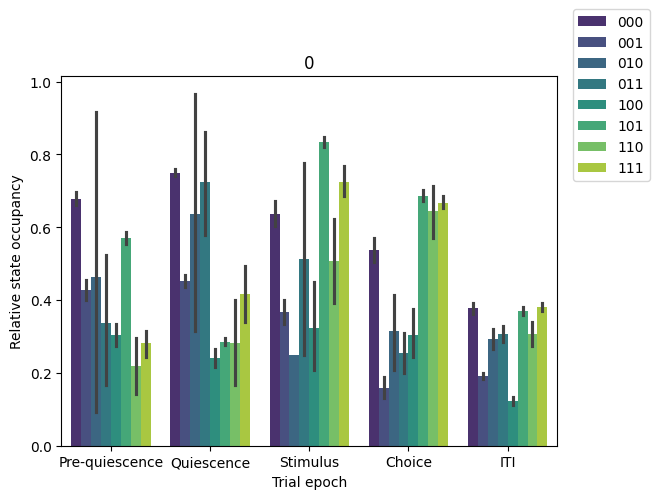

/tmp/ipykernel_42178/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


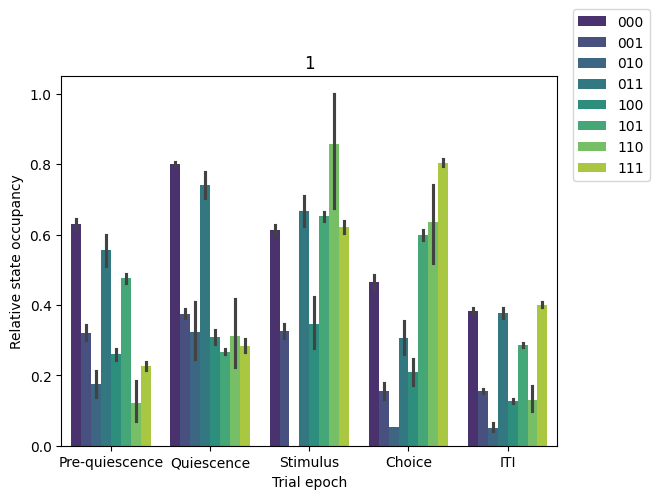

/tmp/ipykernel_42178/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


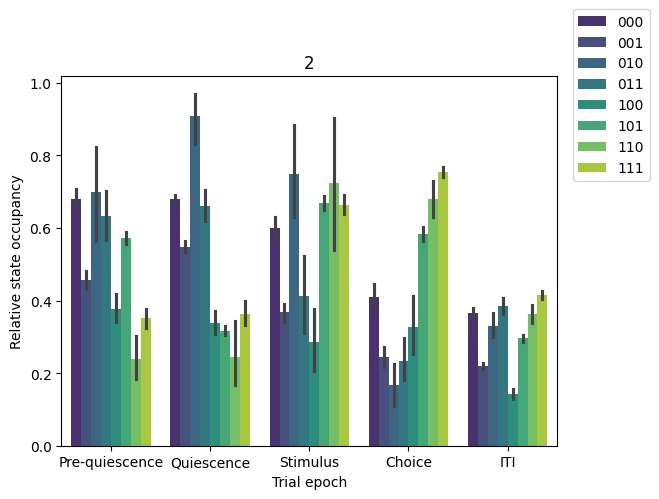

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


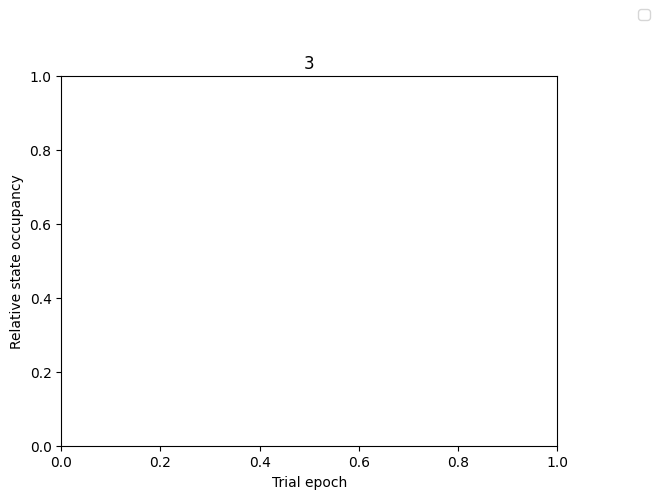

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


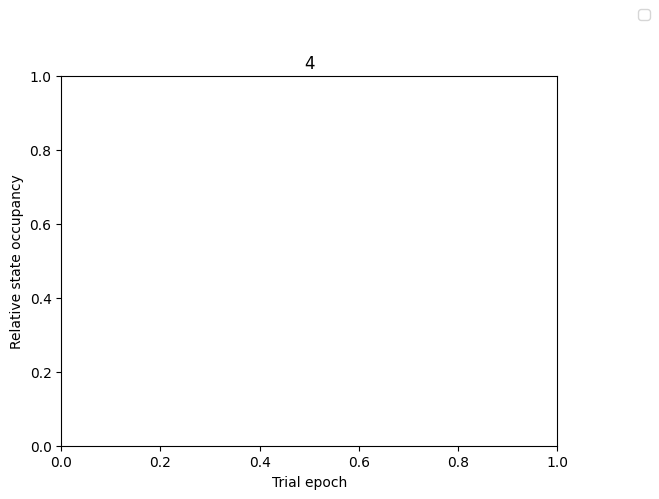

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


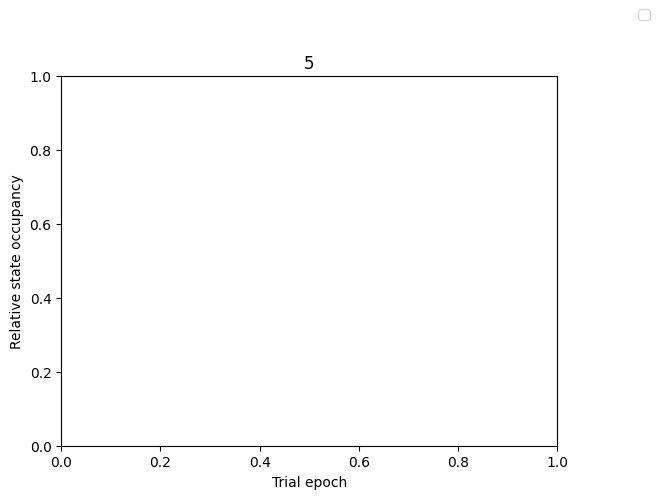

In [ ]:
for c, cluster in enumerate(range(6)):
    use_data = df_cluster.loc[df_cluster['cluster']==cluster]
    use_data = revert_to_original(use_data)
    sns.barplot(x='broader_label', y='relative_frequency', hue='original_states', 
                order=['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI'], 
                hue_order = ['000', '001', '010', '011', '100', '101', '110','111'], data=use_data, palette='viridis')
    plt.xlabel('Trial epoch')
    plt.ylabel('Relative state occupancy')
    plt.legend(bbox_to_anchor=(1.2, 1.2))
    plt.title(cluster)
    plt.show()